In [3]:
from typing import Dict, List, Union, Tuple, Optional, Set
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil

In [23]:
# Constants
BASE_PATH = os.path.join("D:\\", "Workspaces", "vscode-workspace", "ai_x_medicine", "data")
WATER_DATASET_FILENAME = "env_water.csv"
EARTH_DATASET_FILENAME = "env_earth.csv"
FIRE_DATASET_FILENAME = "env_fire.csv"
WOOD_DATASET_FILENAME = "env_wood.csv"
METAL_DATASET_FILENAME = "env_metal.csv"

FIRE_OUTPUT_PATH = os.path.join(BASE_PATH, "env_fire-new.csv")
OUTPUT_PATH = os.path.join(BASE_PATH, "out", "economical-pain.csv")

In [67]:
# Util functions
def is_valid_data(val):
    if pd.notnull(val) and str(val).strip() != '':
        return True
    return False

def compute_pain() -> float:
    pass

def bar_plot(dataframe: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    dataframe.plot(kind='bar')
    plt.xlabel('Countries')
    plt.ylabel('values')
    # plt.title('')
    plt.tight_layout()
    plt.show()

def normalize_data(dataframe: pd.DataFrame, do_log: bool = False):
    max_val = dataframe["value"].max()
    dataframe['value'] = dataframe["value"].apply(lambda x: np.log(x) / np.log(max_val) if do_log else x / max_val)
    

In [81]:
# [x] transform Earth data
df_earth = pd.read_csv(os.path.join(BASE_PATH, EARTH_DATASET_FILENAME))

res_earth: Dict[str, Tuple[int, float]] = {}
for _, row in df_earth.iterrows():
    country = row["Entity"]
    year = row["Year"]
    value = row["Red List Index"]
    
    if country in res_earth:
        cur_year, cur_val = res_earth[country]
        if cur_year < year:
            res_earth[country] = year, value
    else:
        res_earth[country] = year, value

df_res = []
for key, value in res_earth.items():
    df_res.append({
        "Country": key,
        "value": 1-value[1]
    })
df_earth = pd.DataFrame(df_res)
df_earth.to_csv(os.path.join(BASE_PATH, "out", "env_pains", "env-earth-pain.csv"), index=False)

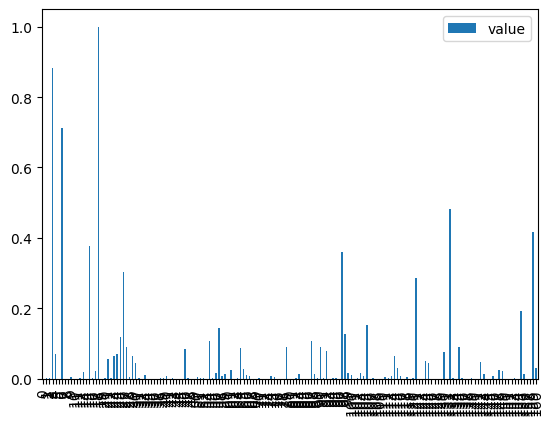

In [68]:
# [x] transform fire data (2024)
mode = 1
if mode == 0:
    df_fire = pd.read_csv(os.path.join(BASE_PATH, FIRE_DATASET_FILENAME))

    res_fire: Dict[str, float] = {}
    for _, row in df_fire.iterrows():
        country = row["Entity"]
        year = row["Year"]
        value = row["Annual area burnt by wildfires"]
        
        if year == 2024 and not "world" in country.lower():
            res_fire[country] = value

    df_res = []
    for key, value in res_fire.items():
        df_res.append({
            "Country": key,
            "fire_pain": value
        })

    df_fire = pd.DataFrame(df_res)
    df_fire.to_csv(FIRE_OUTPUT_PATH)
    max_fire = df_fire["fire_pain"].max()
    print(max_fire)
    #df_fire["fire_pain"] = df_fire["fire_pain"].apply(lambda x: x / max_fire)
    #df_fire.plot(kind="bar")

else:
    df_fire = pd.read_csv(os.path.join(BASE_PATH, "env_fire-sov.csv"))
    normalize_data(df_fire)
    df_fire.plot(kind="bar")
    df_fire.to_csv(os.path.join(BASE_PATH, "out", "env-fire-pain.csv"), index=False)


<Axes: >

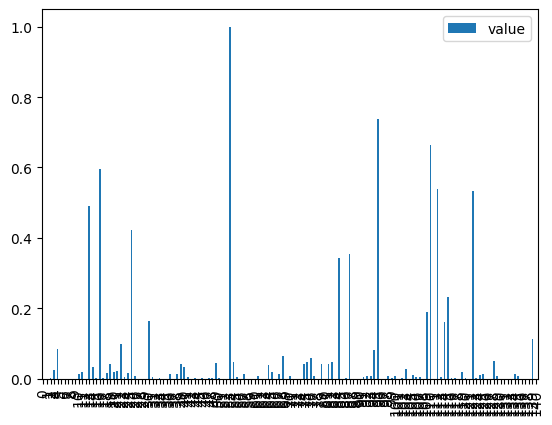

In [69]:
# [x] transform water data
df_water = pd.read_csv(os.path.join(BASE_PATH, WATER_DATASET_FILENAME))

res_water: Dict[str, float] = {}
for _, row in df_water.iterrows():
    country = row["Country"]
    year = row["Start Year"]
    value = row["Total Affected"]
    if 2019 < year <= 2025:
        if country not in res_water:
            res_water[country] = 0
        res_water[country] += value

df_res = []
for key, val in res_water.items():
    df_res.append({
        "Country": key,
        "value": val
    })

df_water = pd.DataFrame(df_res)
normalize_data(df_water)
df_water.to_csv(os.path.join(BASE_PATH, "out", "env-water-pain.csv"), index=False)

df_water.plot(kind="bar")


<Axes: >

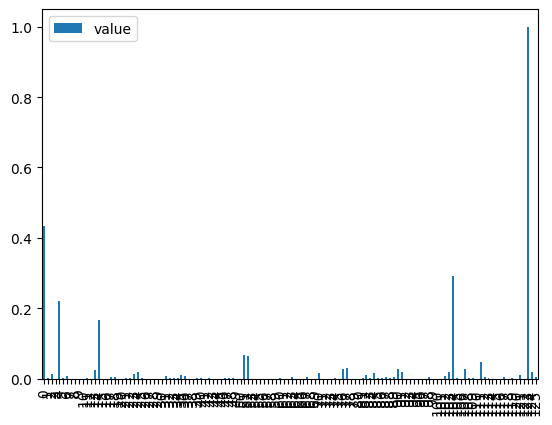

In [80]:
# [x] transform wood data
df_wood = pd.read_csv(os.path.join(BASE_PATH, WOOD_DATASET_FILENAME))

res_wood: Dict[str, float] = {}
for _, row in df_wood.iterrows():
    country = row["Entity"]
    year = row["Year"]
    value = row["Deforestation"]
    if 2015 <= year <= 2020:
        if country not in res_wood:
            res_wood[country] = 0
        res_wood[country] += value

df_res = []
for key, value in res_wood.items():
    df_res.append({
        "Country": key,
        "value": value
    })
df_wood = pd.DataFrame(df_res)
normalize_data(df_wood)
df_wood.to_csv(os.path.join(BASE_PATH, "out", "env_pains", "env-wood-pain.csv"), index=False)
df_wood.plot(kind="bar")

<Axes: >

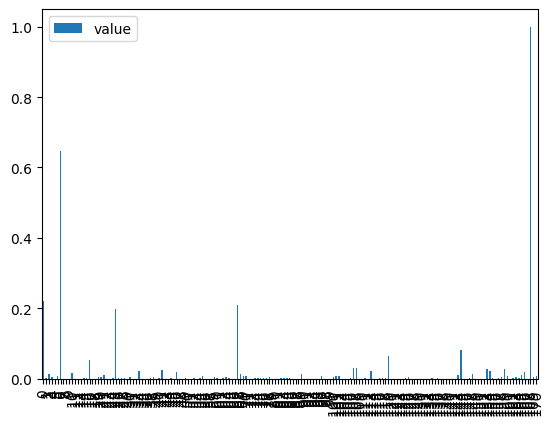

In [72]:
# [x] transform metal data
df_metal = pd.read_csv(os.path.join(BASE_PATH, METAL_DATASET_FILENAME))

res_metal = []
for _, row in df_metal.iterrows():
    country = row["Entity"]
    value = row["Mismanaged plastic waste (metric tons year-1)"]
    res_metal.append({
        "Country": country,
        "value": value
    })

df_metal = pd.DataFrame(res_metal)
normalize_data(df_metal)
df_metal.to_csv(os.path.join(BASE_PATH, "out", "env-metal-pain.csv"), index=False)
df_metal.plot(kind="bar")

In [82]:
# ENV PAIN
elements = ["fire", "earth", "water", "metal", "wood"]
DFS = {}
country_set = None
for elem in elements:
    df_cur = pd.read_csv(os.path.join(BASE_PATH, "out", "env_pains", f"env-{elem}-pain.csv"))
    if country_set is None:
        country_set = set(df_cur["Country"])
    else:
        country_set = set(df_cur["Country"]).intersection(country_set)
    DFS[elem] = df_cur

env_result = []
for _, row in DFS["fire"].iterrows():
    country = row["Country"]
    if country in country_set:
        pain_val = 0
        for element in elements:
            df_cur = DFS[element]
            cur_val = df_cur.loc[df_cur["Country"] == country].iloc[0]["value"]
            if cur_val > pain_val:
                pain_val = cur_val
        env_result.append({
            "Country": country,
            "value": pain_val / len(elements)
        })

df_env_pain = pd.DataFrame(env_result)
df_env_pain.to_csv(os.path.join(BASE_PATH, "out", "hollistic_pains", "env-pain.csv"), index=False)

print(country_set)
print(len(country_set))

{'Bulgaria', 'Georgia', 'New Zealand', 'Indonesia', 'Suriname', 'Peru', 'Liberia', 'China', 'Croatia', 'Ukraine', 'Canada', 'Cameroon', 'Romania', 'Equatorial Guinea', 'Papua New Guinea', 'Algeria', 'Bangladesh', 'El Salvador', 'Togo', 'Ecuador', 'Chile', 'Costa Rica', 'Spain', 'Morocco', 'Mexico', 'Nigeria', 'Germany', 'Latvia', 'Iraq', 'Argentina', 'Guatemala', 'Senegal', 'South Africa', 'Djibouti', 'Somalia', 'Myanmar', 'Mozambique', 'Gabon', 'Poland', 'Slovenia', 'Thailand', 'Belgium', 'Guyana', 'Zimbabwe', 'Mauritania', 'Panama', 'India', 'Honduras', 'Sweden', 'Brazil', 'Sudan', 'Colombia', 'Tunisia'}
53


# EMOTIONAL DATA

In [ ]:
# [x] transform emotional pain
df_emo = pd.read_csv(os.path.join(BASE_PATH, "emotional.csv"), index_col=False)
res_emo = []
for _, row in df_emo.iterrows():
    country = row["country"]
    pain_val = row["pain_score"]
    res_emo.append({
        "Country": country,
        "value": pain_val
    })
df_emo = pd.DataFrame(res_emo)
df_emo.to_csv(os.path.join(BASE_PATH, "out", "emo-pain.csv"), index=False)